In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import re

regex = re.compile(r'^[\d]+_x=([-\d.]+)_z=([-\d.]+)_a=([-\d.]+)_h=([-\d.]+)[.]csv$')

def label_from_path(path):
    label = path.split('\\')[-1] # PLATFORM DEPENDENT!
    m = regex.match(label)
    out = [float(x) for x in m.groups()]
    return torch.tensor(out, dtype=torch.float)

In [3]:
def data_from_path(path):
    data = pd.read_csv(path, sep=';')

    time = data.values[:,0]
    vx   = data.values[:,1::2]
    vz   = data.values[:,2::2]
    vabs = (vx ** 2 + vz ** 2) ** (1/2)
    
    vx   = torch.from_numpy(vx)
    vz   = torch.from_numpy(vz)
    vabs = torch.from_numpy(vabs)
    
    vx_fft   = torch.view_as_real(torch.fft.fft(vx)).permute(2, 0, 1)
    vz_fft   = torch.view_as_real(torch.fft.fft(vz)).permute(2, 0, 1)
    vabs_fft = torch.view_as_real(torch.fft.fft(vabs)).permute(2, 0, 1)

    ret = torch.cat([vx.unsqueeze(0), vz.unsqueeze(0), vabs.unsqueeze(0), vx_fft, vz_fft, vabs_fft], dim=0)

    return ret

In [4]:
class CSVDataset(Dataset):
    def __init__(self, path, device):
        self.device = device
        self.csv_list = [
            (path + "\\" + i) for i in os.listdir(path) if i.split('.')[-1] == 'csv'
        ]

    def __getitem__(self, item):
        d = data_from_path(self.csv_list[item]).to(device=device, dtype=torch.float)
        l = label_from_path(self.csv_list[item]).to(device=device, dtype=torch.float)
        return d, l

    def __len__(self):
        return len(self.csv_list)

In [5]:
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()

        self.feature_extractor = nn.Sequential(
            #        in  out  ker size
            nn.Conv2d(9, 64, 3),     # 9 = len([v_x, v_y, v_abs, 2*fft_vx, 2*fft_vy, 2*fft_vabs, ])
            nn.MaxPool2d(2, 2), 
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 512, 3, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            nn.Conv2d(512, 1024, 3, 2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),

            nn.Conv2d(1024, 512, 2),
        )

        self.linear = nn.Linear(45, 256)
        self.conv = nn.Sequential(
            nn.Conv2d(512, 1, 1),
            nn.ReLU(inplace=True)
            )

        self.linear2 = nn.Linear(256, 4) # 4 = x, z, a, h

    def forward(self, input):
        x = self.feature_extractor(input)
        x = x.permute(0, 1, 3, 2)
        x = self.linear(x)
        x = self.conv(x)
        x = x.squeeze(1).squeeze(1)
        x = self.linear2(x)

        return x

In [6]:
predictor = Predictor().to(device)
data_loader = DataLoader(CSVDataset(".\\csv", device), batch_size=8, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(predictor.parameters(), lr=0.0003)

In [7]:
from tqdm import tqdm

num_epochs = 25
all_loss = []

for epoch in range(num_epochs):
    progress = tqdm(data_loader)
    running_loss = []
    for inputs, label in progress:
        # zero the parameter gradients
        optimizer.zero_grad()
        # predict
        outputs = predictor(inputs)
        # loss
        loss = loss_fn(outputs, label)
        running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        progress.set_description(f"loss: {loss.item()}")
    
    all_loss.append(running_loss)
    torch.save(predictor.state_dict(), f'.\\weights\\lastest_{epoch}_{np.mean(running_loss)}')

print('Finished Training')

loss: 285.3267822265625: 100%|███████████████████████████████████████████████████████| 750/750 [08:59<00:00,  1.39it/s]

Finished Training


In [14]:
from tqdm import tqdm

predictor = Predictor().to(device)
loss_fn = nn.MSELoss()

weight_path = ".\\w3"
epoch_list = [ (weight_path + "\\" + i) for i in os.listdir(weight_path)]

out_list = []

print(epoch_list)

['.\\w3\\lastest_0_37995.8162820638', '.\\w3\\lastest_10_847.6630532633463', '.\\w3\\lastest_11_796.7646643676758', '.\\w3\\lastest_12_689.7228363647461', '.\\w3\\lastest_13_683.1011740722656', '.\\w3\\lastest_14_666.5717091674804', '.\\w3\\lastest_15_656.4136258138021', '.\\w3\\lastest_16_512.8400864461263', '.\\w3\\lastest_17_498.35995985921227', '.\\w3\\lastest_18_495.0183553161621', '.\\w3\\lastest_19_446.92242497762044', '.\\w3\\lastest_1_3715.439570963542', '.\\w3\\lastest_20_514.0208389282227', '.\\w3\\lastest_21_453.59397260538736', '.\\w3\\lastest_22_478.74707580566405', '.\\w3\\lastest_23_359.4045446370443', '.\\w3\\lastest_24_401.64379184977213', '.\\w3\\lastest_2_2604.4470025227865', '.\\w3\\lastest_3_1773.6341033528645', '.\\w3\\lastest_4_1547.2999309895833', '.\\w3\\lastest_5_1316.9536556803384', '.\\w3\\lastest_6_1197.787421142578', '.\\w3\\lastest_7_1003.76023832194', '.\\w3\\lastest_8_1064.9276525472005', '.\\w3\\lastest_9_843.9003755289714']


In [15]:
for fname in epoch_list:
    predictor.load_state_dict(torch.load(fname))
    test_data_loader = DataLoader(CSVDataset(".\\csv_test", device), batch_size=8, shuffle=True)
    total_loss = 0
    for data, label in tqdm(test_data_loader):
        with torch.no_grad():
            outputs = predictor(data)
            total_loss += loss_fn(outputs, label)
    
    out_list.append( (fname, total_loss / len(test_data_loader)) )

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:38<00:00,  1.96it/s]


Train loss        Test loss
37995.8162820638 4358.88720703125
847.6630532633463 1021.8834838867188
796.7646643676758 532.3521728515625
689.7228363647461 1297.5308837890625
683.1011740722656 962.8535766601562
666.5717091674804 730.9874877929688
656.4136258138021 586.3178100585938
512.8400864461263 435.5487976074219
498.35995985921227 519.0006103515625
495.0183553161621 566.9306640625
446.92242497762044 435.7857971191406
3715.439570963542 2900.21435546875
514.0208389282227 461.0843811035156
453.59397260538736 606.5643920898438
478.74707580566405 382.3622131347656
359.4045446370443 634.227294921875
401.64379184977213 441.9477844238281
2604.4470025227865 2201.61279296875
1773.6341033528645 1319.8623046875
1547.2999309895833 3375.68212890625
1316.9536556803384 1123.096435546875
1197.787421142578 989.2932739257812
1003.76023832194 1054.9373779296875
1064.9276525472005 752.2247314453125
843.9003755289714 667.4841918945312


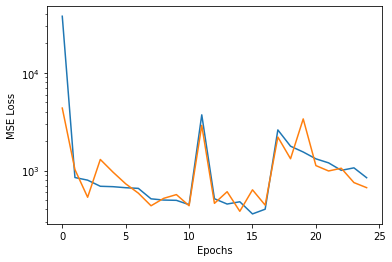

In [16]:
import matplotlib.pyplot as plt

a = []
b = []

print("Train loss        Test loss")
for x in out_list:
    a.append(float(x[0].split('_')[-1]))
    b.append(float(x[1]))
    print(a[-1], b[-1])
    
plt.yscale("log")

plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

plt.plot(a)
plt.plot(b)
plt.show()

In [17]:
# BEST EPOCH IS 14
print("Train loss        Test loss")
print(a[14], b[14])

Train loss        Test loss
478.74707580566405 382.3622131347656


In [9]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz\\bin\\'

In [11]:
from torchviz import make_dot

predictor = Predictor().to(device)
predictor.load_state_dict(torch.load('.\\w3\\lastest_8_1064.9276525472005'))
data_loader = DataLoader(CSVDataset(".\\csv", device), batch_size=8, shuffle=True)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(predictor.parameters(), lr=0.0003)

test_data_loader = DataLoader(CSVDataset(".\\csv_test", device), batch_size=8, shuffle=True)

data, label = next(iter(test_data_loader))
yhat = predictor(data)

make_dot(yhat, params=dict(list(predictor.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'